In [1]:
import numpy as np
import pandas as pd
import time as tm
import math # to calculate distance between servers

#import sklearn to cluster
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA # use pca reduce dims
from mpl_toolkits.mplot3d import Axes3D # plot 3d figure
from s_dbw import S_Dbw # evaluate clustering

from matplotlib import pyplot

from sklearn.cluster import MeanShift # a clustering algorithm decide the n_cluster automatically

In [2]:
# Data Processing - read data from .csv file

data_loc = 'us'
file = f'../dataset/{data_loc}.csv'

df = pd.read_csv(file)
df = pd.DataFrame(df)

time_start = tm.time()

ip_time = dict()
special_chr = ["{", "}", "'", ":", " "]

for i in range(len(df)):
    raw_points = df['transactionList'][i]
    points = ''.join(e for e in raw_points if e not in special_chr)
    points = points.split(",")
    for j in range(len(points)):
        time = points[j][:17]
        ip = points[j][17:]
        if ip not in ip_time:
            ip_time[ip] = [time]
        else:
            ip_time[ip].append(time)

time_end = tm.time()
runtime = time_end - time_start
print(f'runtime: {runtime} second')

total_num = len(ip_time)
print(f'num of total server: {total_num}')

print(f'Data Size of "{data_loc}": {len(df)}')

C:\Users\smart\AppData\Local\Temp\ipykernel_21976\901789945.py:6: DtypeWarning: Columns (1,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


runtime: 43.95571327209473 second
num of total server: 619
Data Size of "us": 284249


In [3]:
# select specific period from the dataset, "ip_time"

def get_ip_time(ip_data=ip_time, period='2021', period_ip_time=None): # period_ip_time: use to accumulate date
    if period_ip_time is None:
        period_ip_time = dict()
    if type(period) == str:
        len_p = len(period)
        for ip in ip_data:
            for time in ip_data[ip]:
                if time[0:len_p] == period:
                    if ip not in period_ip_time:
                        period_ip_time[ip] = [time]
                    else:
                        period_ip_time[ip] += [time]
    elif type(period) == list: #[time_1, time_2, ...]
        period_ip_time = get_ip_time(period=period[0])
        for time_i in period[1:]:
            period_ip_time = get_ip_time(period=time_i, period_ip_time=period_ip_time)
    return period_ip_time

# get 2021 data - US-All
data_us_all = get_ip_time(period='2021')

# get US-1 data - 2021-05-07~2021-05-16 (for us dataset)
us_1 = ['2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11',
            '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16']
data_us_1 = get_ip_time(period=us_1)

# check the data
for ip in data_us_1:
    print(f'ip: {ip}')
    print(data_us_1[ip][:5])
    break

ip: 52.223.228.27
['2021-05-07T000111', '2021-05-07T002416', '2021-05-07T003212', '2021-05-07T002644', '2021-05-07T003952']


In [4]:
# setup hour axis for below chart
hour_axis = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

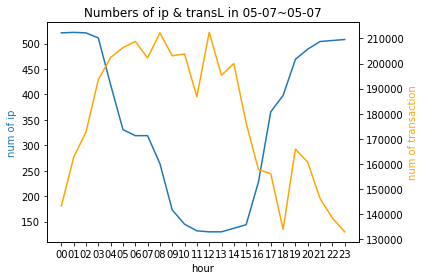

Figure 4.1: Number of IPs and Transaction Counts in US-1


In [5]:
# Figure 4.1: Number of IPs and Transaction Counts in US-1

data_choose = data_us_1

hour_ip_count = dict()
hour_transaction_count = dict()

for ip in data_choose:
    for time in data_choose[ip]:
        date = time[5:10]
        hour = time[11:13]
        if hour not in hour_ip_count:
            hour_ip_count[hour] = [ip]
            hour_transaction_count[hour] = 1
        elif ip not in hour_ip_count[hour]:
            hour_ip_count[hour].append(ip)
            hour_transaction_count[hour] += 1
        else: hour_transaction_count[hour] += 1
            
ip_count_axis = list()
trans_count_axis = list()
for key in hour_axis:
    if key not in hour_ip_count:
        ip_count_axis.append(0)
        trans_count_axis.append(0)
    else:
        ip_count_axis.append(len(hour_ip_count[key]))
        trans_count_axis.append(hour_transaction_count[key])

fig, ax1 = pyplot.subplots()
date_period = f'{us_1[0][-5:]}~{us_1[0][-5:]}'
pyplot.title(f'Numbers of ip & transL in {date_period}')
pyplot.xlabel('hour')
ax2 = ax1.twinx()

ax1.set_ylabel('num of ip', color='tab:blue')
ax1.plot(hour_axis, ip_count_axis, color='tab:blue')
ax1.tick_params(axis='y')

ax2.set_ylabel('num of transaction', color='orange')
ax2.plot(hour_axis, trans_count_axis, color='orange')
ax2.tick_params(axis='y')

fig.tight_layout()
pyplot.show()

print('Figure 4.1: Number of IPs and Transaction Counts in US-1')

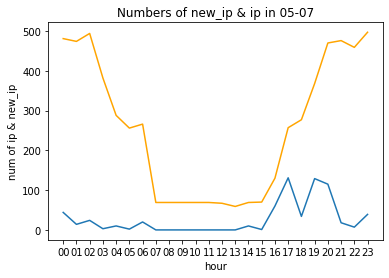

Figure 4.2 ~ 4.6: Number of 'new IPs' and 'IPs' on 05-07


In [6]:
# Figure 4.2 ~ 4.6: Number of 'new IPs' and 'IPs' on {date} (may-7 ~ may-15)
# change "date_choose" to get other results in Figure 4.2 ~ 4.6

date_choose = '2021-05-07'
data_choose = data_us_1

# data setup - 23:00~23:59 on last date + date_choose
if date_choose[-1] != '0':
    last_date_hour = date_choose[:-1] + str(int(date_choose[-1])-1) + 'T23'
else: last_date_hour = date_choose[:-2] + str(int(date_choose[-2])-1) + '9T23'
choose_data = get_ip_time(ip_data=data_choose, period=[last_date_hour, date_choose])

ip_hour_overlap_count = 0 # [1000, 500, 100, 200, ...]
ip_hour_count = 0 # [1000, 1400, 700, 800]

for ip in choose_data:
    ip_hour_current = ''
    ip_hour_record = [] # ['23', '00', '01', '03', ...] (start from last date '23')
    ip_hour_01record = [] # [1,1,1,0,1, ...] (would record '23') -> ip_hour_count 
    new_ip_01record = [] # [1,0,0,1, ...] (not record '23') -> ip_hour_overlap_count 
    
    # ip_hour_record
    for time in choose_data[ip]:
        hour = time[11:13]
        if hour != ip_hour_current:
            ip_hour_current = hour
            ip_hour_record.append(hour)
            
    # ip_hour_01record
    if ip_hour_record[0] == '23': ip_hour_01record.append(1)
    else: ip_hour_01record.append(0)
    for hour in hour_axis: # '00'~'23'
        if hour not in ip_hour_record: ip_hour_01record.append(0)
        else: ip_hour_01record.append(1)
            
    # new_ip_01record
    for i in range(len(hour_axis)): # '00'~'23'
        if ip_hour_01record[i]==0 and ip_hour_01record[i+1]==1: # new ip show
            new_ip_01record.append(1)
        else: new_ip_01record.append(0)
    
    # ip_hour_overlap_count
    if type(ip_hour_overlap_count) != np.ndarray: ip_hour_overlap_count = np.array(new_ip_01record)
    else: ip_hour_overlap_count += np.array(new_ip_01record)
        
    # ip_hour_count
    if type(ip_hour_count) != np.ndarray: ip_hour_count = np.array(ip_hour_01record[1:]) # '00'~'23'
    else: ip_hour_count += np.array(ip_hour_01record[1:])
        
# plot
pyplot.title(f'Numbers of new_ip & ip in {date_choose[-5:]}')
pyplot.xlabel('hour')
pyplot.ylabel('num of ip & new_ip')
pyplot.plot(hour_axis, list(ip_hour_overlap_count), color='tab:blue', label='new_ip')
pyplot.plot(hour_axis, list(ip_hour_count), color='orange', label='total_ip')
pyplot.show()

print(f"Figure 4.2 ~ 4.6: Number of 'new IPs' and 'IPs' on {date_choose[-5:]}")

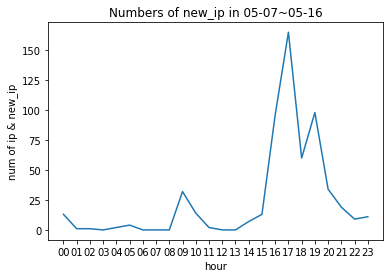

Figure 4.7: Number of 'new IPs' in US-1


In [7]:
# Figure 4.7: Number of 'new IPs' in US-1

date = '05-07~05-16'
data_choose = data_us_1

hour_ip = dict() # {'00': [ip1, ip2, ...], '01':[ip1, ...]}
transaction_count = dict()
new_ip_count = []

for ip in data_choose:
    for time in data_choose[ip]:
        hour = time[11:13]
        if hour not in hour_ip:
            hour_ip[hour] = [ip]
            transaction_count[hour] = 1
        elif ip not in hour_ip[hour]:
            hour_ip[hour].append(ip)
            transaction_count[hour] += 1
        else: transaction_count[hour] += 1
            

temp_count = 0
for ip in hour_ip[hour_axis[0]]: # '00'
    if ip not in hour_ip[hour_axis[-1]]:
        temp_count += 1
new_ip_count.append(temp_count)
        
for i in range(1, len(hour_axis)): #'01'~'23'
    temp_count = 0
    for ip in hour_ip[hour_axis[i]]:
        if ip not in hour_ip[hour_axis[i-1]]:
            temp_count += 1
    new_ip_count.append(temp_count)
    
# plot
pyplot.title(f'Numbers of new_ip in {date}')
pyplot.xlabel('hour')
pyplot.ylabel('num of ip & new_ip')
pyplot.plot(hour_axis, new_ip_count, color='tab:blue')
pyplot.show()

print("Figure 4.7: Number of 'new IPs' in US-1")

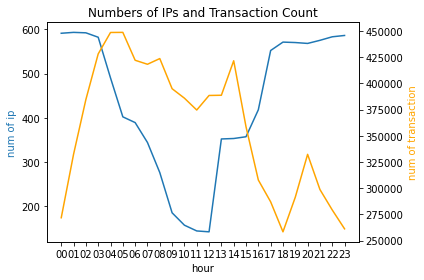

Figure 4.9: Number of IPs and Transaction Count in Every Hour - US-All


In [8]:
# Figure 4.9: Number of IPs and Transaction Count in Every Hour - US-All

data_choose = data_us_all

hour_ip_count = dict()
hour_transaction_count = dict()

for ip in data_choose:
    for time in data_choose[ip]:
        date = time[5:10]
        hour = time[11:13]
        if hour not in hour_ip_count:
            hour_ip_count[hour] = [ip]
            hour_transaction_count[hour] = 1
        elif ip not in hour_ip_count[hour]:
            hour_ip_count[hour].append(ip)
            hour_transaction_count[hour] += 1
        else: hour_transaction_count[hour] += 1
            
ip_count_axis = list()
trans_count_axis = list()
for key in hour_axis:
    if key not in hour_ip_count:
        ip_count_axis.append(0)
        trans_count_axis.append(0)
    else:
        ip_count_axis.append(len(hour_ip_count[key]))
        trans_count_axis.append(hour_transaction_count[key])

fig, ax1 = pyplot.subplots()
date_period = f'{us_1[0][-5:]}~{us_1[0][-5:]}'
pyplot.title(f'Numbers of IPs and Transaction Count')
pyplot.xlabel('hour')
ax2 = ax1.twinx()

ax1.set_ylabel('num of ip', color='tab:blue')
ax1.plot(hour_axis, ip_count_axis, color='tab:blue')
ax1.tick_params(axis='y')

ax2.set_ylabel('num of transaction', color='orange')
ax2.plot(hour_axis, trans_count_axis, color='orange')
ax2.tick_params(axis='y')

fig.tight_layout()
pyplot.show()
    
print("Figure 4.9: Number of IPs and Transaction Count in Every Hour - US-All")

In [9]:
# define the k-means clustering function

def kmeans_cluster(model, n_clusters=2, pca_components=False, plot=False, show_centers=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             random_state=0,
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model) # len(yhat) = num of ip
    if(show_centers):print(kmeans.cluster_centers_)
    if(plot):
        pyplot.title(f'kmeans-cluster: {n_clusters}, pca: {bool(pca_components)}')
        if type(plot) == list:
            pyplot.xlabel(plot[0])
            pyplot.ylabel(plot[1])
        clusters = np.unique(yhat)
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            pyplot.scatter(model[row_ix, 0], model[row_ix, 1])
        pyplot.show()
    score = S_Dbw(model, yhat)
    return yhat, score

def get_ip_periods_count(ip, ip_time, hour_period):
    hour_count = np.zeros((len(hour_period),), dtype=int)
    for time in ip_time[ip]:
        for i in range(len(hour_period)):
            if time[11:13] in hour_period[i]:
                hour_count[i] += 1
                continue
    return hour_count

class_0(blue): [2799, 1627, 1561]
class_1(orange): [142842, 98985, 129158]
class_2(green): [4269, 39357, 4388]


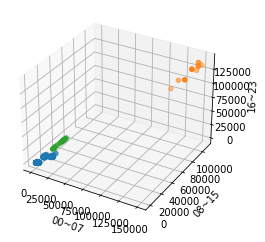

Figure 4.10: Clustering Result with K-means


In [10]:
# Figure 4.10: Clustering Result with K-means

data_choose = data_us_all

# clustering parameters
n_periods = 3 # how many attributes
slide_hour = 0 # change attributes by sliding time windows
num_clusters = 3
pca_choose = False

# set hour periods for attributes
period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

# set attributes - transaction counts in n hour_periods
count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)

# 3d plot
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')
ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')
ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')

clusters = np.unique(yhat_count_hour3)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for cluster in clusters:
    row_ix = np.where(yhat_count_hour3 == cluster)
    ax.scatter(X_count_hour3[row_ix, 0], X_count_hour3[row_ix, 1], X_count_hour3[row_ix, 2], color=colors[cluster])
    print(f'class_{cluster}({colors[cluster][4:]}): {[round(np.mean(X_count_hour3[row_ix, 0])), round(np.mean(X_count_hour3[row_ix, 1])), round(np.mean(X_count_hour3[row_ix, 2]))]}')

pyplot.show()

print("Figure 4.10: Clustering Result with K-means")

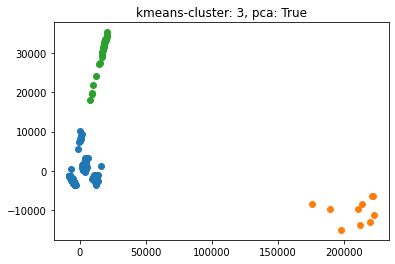

Figure 4.11: Clustering Result with PCA


In [11]:
# Figure 4.11: Clustering Result with PCA

data_choose = data_us_all

# clustering parameters
n_periods = 3
slide_hour = 0
num_clusters = 3
pca_choose = 2

# set hour periods for attributes
period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

# set attributes - transaction counts in n hour_periods
count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=True, show_centers=False)

print("Figure 4.11: Clustering Result with PCA")

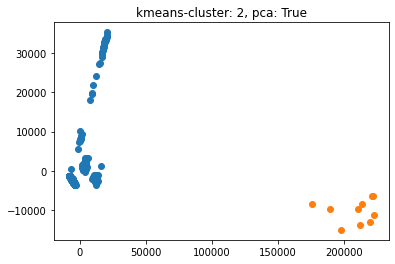

n_cluster: 2
S_Dbw: 0.5267170413404887


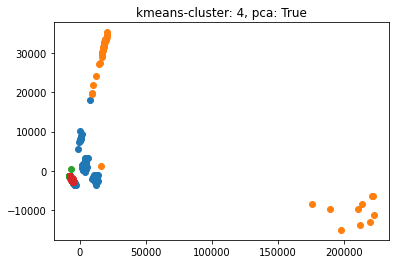

n_cluster: 4
S_Dbw: 1.0620020470782143

Figure 4.12: Number of Clusters equal 2 or 4


In [12]:
# Figure 4.12: Number of Clusters equal 2 or 4

data_choose = data_us_all

# clustering parameters
n_periods = 3 # how many attributes
slide_hour = 0 # change attributes by sliding time windows
num_clusters = 2
pca_choose = 2

# set hour periods for attributes
period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

# set attributes - transaction counts in n hour_periods
count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)

yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=True, show_centers=False)
print(f'n_cluster: {num_clusters}')
print(f'S_Dbw: {score_count_hour3}')

num_clusters = 4
yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=True, show_centers=False)
print(f'n_cluster: {num_clusters}')
print(f'S_Dbw: {score_count_hour3}\n')

print("Figure 4.12: Number of Clusters equal 2 or 4")

In [13]:
# Table 4.1: S_Dbw Scores with n_period = 3, 4, 6 (n_cluster=3)

data_choose = data_us_all

# clustering parameters
num_clusters = 3
pca_choose = 2

for n_periods in [3,4,6]:
    period_len = len(hour_axis)//n_periods
    for slide_hour in range(period_len):
        hour_period = []
        for i in range(n_periods-1):
            hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
        hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])
        
        count_period3 = []
        for _ip in data_choose:
            period3 = get_ip_periods_count(_ip, data_choose, hour_period)
            count_period3.append(period3)
        X_count_hour3 = np.array(count_period3)
        yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)
        print(f'n_periods: {n_periods}, slide_hour:{slide_hour}, S_Dbw: {round(score_count_hour3, 4)}')

print("\nTable 4.1: S_Dbw Scores with n_period = 3, 4, 6 (n_cluster=3)")

n_periods: 3, slide_hour:0, S_Dbw: 0.3601
n_periods: 3, slide_hour:1, S_Dbw: 0.3549
n_periods: 3, slide_hour:2, S_Dbw: 0.3504
n_periods: 3, slide_hour:3, S_Dbw: 0.4792
n_periods: 3, slide_hour:4, S_Dbw: 0.527
n_periods: 3, slide_hour:5, S_Dbw: 0.4227
n_periods: 3, slide_hour:6, S_Dbw: 0.3818
n_periods: 3, slide_hour:7, S_Dbw: 0.3635
n_periods: 4, slide_hour:0, S_Dbw: 0.3946
n_periods: 4, slide_hour:1, S_Dbw: 0.3584
n_periods: 4, slide_hour:2, S_Dbw: 0.3591
n_periods: 4, slide_hour:3, S_Dbw: 0.3598
n_periods: 4, slide_hour:4, S_Dbw: 0.4601
n_periods: 4, slide_hour:5, S_Dbw: 0.448
n_periods: 6, slide_hour:0, S_Dbw: 0.3586
n_periods: 6, slide_hour:1, S_Dbw: 0.4549
n_periods: 6, slide_hour:2, S_Dbw: 0.4653
n_periods: 6, slide_hour:3, S_Dbw: 0.4695

Table 4.1: S_Dbw Scores with n_period = 3, 4, 6 (n_cluster=3)


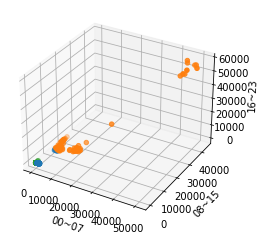

S_Dbw: 1.1467056156867095
US-1



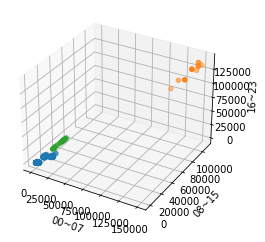

S_Dbw: 0.3601130751852925
US-All

Figure 4.13: Clustering Results in US-1 and US-All


In [14]:
# Figure 4.13: Clustering Results in US-1 and US-All

n_periods = 3 
slide_hour = 0 
num_clusters = 3
pca_choose = 2

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

####################

# left figure - US-1
data_choose = data_us_1

count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')
ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')
ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')

clusters = np.unique(yhat_count_hour3)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for cluster in clusters:
    row_ix = np.where(yhat_count_hour3 == cluster)
    ax.scatter(X_count_hour3[row_ix, 0], X_count_hour3[row_ix, 1], X_count_hour3[row_ix, 2], color=colors[cluster])

pyplot.show()
print(f'S_Dbw: {score_count_hour3}')
print('US-1\n')

#######################

# right figure - US-All
data_choose = data_us_all

count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)

# 3d plot
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')
ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')
ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')

clusters = np.unique(yhat_count_hour3)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for cluster in clusters:
    row_ix = np.where(yhat_count_hour3 == cluster)
    ax.scatter(X_count_hour3[row_ix, 0], X_count_hour3[row_ix, 1], X_count_hour3[row_ix, 2], color=colors[cluster])

pyplot.show()
print(f'S_Dbw: {score_count_hour3}')
print('US-All\n')

print("Figure 4.13: Clustering Results in US-1 and US-All")

In [15]:
# kmeans_cluster without fixed random seed - each time result could be different

def rm_kmeans_cluster(model, n_clusters=2, pca_components=False, plot=False, show_centers=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             # random_state=0, # remove random seed
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model) # len(yhat) = num of ip
    if(show_centers):print(kmeans.cluster_centers_)
    if(plot):
        pyplot.title(f'kmeans-cluster: {n_clusters}, pca: {bool(pca_components)}')
        if type(plot) == list:
            pyplot.xlabel(plot[0])
            pyplot.ylabel(plot[1])
        clusters = np.unique(yhat)
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            pyplot.scatter(model[row_ix, 0], model[row_ix, 1])
        pyplot.show()
    score = S_Dbw(model, yhat)
    return yhat, score

In [16]:
# Table 4.2: Clustering Results with Number of Clusters = 2 to 8
# note: each time result would be different since there is no fixed random seed in rm_kmeans_cluster

data_choose = data_us_1

n_periods = 3
slide_hour = 0
pca_choose = 2

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)

run_times = 10
for num_clusters in [2,3,4,5,6,7,8]:
    print(f'n_clusters: {num_clusters}')
    sdbw_record = np.zeros(run_times)
    for i in range(run_times):
        yhat_count_hour3, score_count_hour3 = rm_kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)
        sdbw_record[i] = score_count_hour3
    print(f'mean S_Dbw: {np.mean(sdbw_record)}')
    print(f'stdev S_Dbw: {np.std(sdbw_record)}\n')
    
print('Table 4.2: Clustering Results with Number of Clusters = 2 to 8')

n_clusters: 2
mean S_Dbw: 1.2138097463011286
stdev S_Dbw: 0.347768460180756

n_clusters: 3
mean S_Dbw: 0.7643331169681901
stdev S_Dbw: 0.19065389714947423

n_clusters: 4
mean S_Dbw: 0.6228608256794971
stdev S_Dbw: 0.20747864869588045

n_clusters: 5
mean S_Dbw: 0.4922076860785798
stdev S_Dbw: 0.1292665859335817

n_clusters: 6
mean S_Dbw: 0.5122202131275996
stdev S_Dbw: 0.1387793886589668

n_clusters: 7
mean S_Dbw: 0.3611720427686503
stdev S_Dbw: 0.04489218913505027

n_clusters: 8
mean S_Dbw: 0.3447643384780704
stdev S_Dbw: 0.11306618221090563

Table 4.2: Clustering Results with Number of Clusters = 2 to 8


In [17]:
# Table 4.3: Clustering Results with Different Data - n_clusters=3

# I have modified the "cluster number" in the thesis for easier reading, 
# just change the cluster number would get the same result in the thesis

n_cluster = 3
n_periods = 3
slide_hour = 0
pca_choose = 2

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

####################

# US-1

data_choose = data_us_1
print('US-1')

count_period3 = []
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat, score = kmeans_cluster(X_count_hour3, n_clusters=n_cluster, pca_components=2, plot=False, show_centers=False)

class_subnet = dict()
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    for i in row_ix[0]:
        subnet = ip_index[i][:10]
        if yhat[i] not in class_subnet:
            class_subnet[yhat[i]] = {subnet: [ip_index[i]]}
        elif subnet not in class_subnet[yhat[i]]:
            class_subnet[yhat[i]][subnet] = [ip_index[i]]
        elif ip_index[i] not in class_subnet[yhat[i]][subnet]:
            class_subnet[yhat[i]][subnet].append(ip_index[i])
for _class in class_subnet:
    print(f'\ncluster {_class}')
    for key, value in class_subnet[_class].items():
        print(f'{key}: {len(value)}')
        
####################
print('####################')

# US-All

data_choose = data_us_all
print('\nUS-All')

count_period3 = []
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat, score = kmeans_cluster(X_count_hour3, n_clusters=n_cluster, pca_components=2, plot=False, show_centers=False)

class_subnet = dict()
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    for i in row_ix[0]:
        subnet = ip_index[i][:10]
        if yhat[i] not in class_subnet:
            class_subnet[yhat[i]] = {subnet: [ip_index[i]]}
        elif subnet not in class_subnet[yhat[i]]:
            class_subnet[yhat[i]][subnet] = [ip_index[i]]
        elif ip_index[i] not in class_subnet[yhat[i]][subnet]:
            class_subnet[yhat[i]][subnet].append(ip_index[i])
for _class in class_subnet:
    print(f'\ncluster {_class}')
    for key, value in class_subnet[_class].items():
        print(f'{key}: {len(value)}')

        
print('\nTable 4.3: Clustering Results with Different Data - n_clusters=3')

US-1

cluster 0
52.223.226: 67
99.181.97.: 79
52.223.244: 41
192.16.65.: 13

cluster 1
52.223.228: 25
52.223.227: 31
99.181.96.: 10
192.16.65.: 48

cluster 2
52.223.228: 14
99.181.97.: 2
52.223.246: 35
52.223.225: 34
52.223.224: 19
52.223.243: 97
52.223.229: 12
52.223.226: 1
99.181.65.: 1
99.181.96.: 6
52.223.247: 2
52.223.248: 1
####################

US-All

cluster 0
52.223.228: 21
52.223.227: 30
52.223.226: 74
52.223.244: 71
99.181.97.: 83
192.16.65.: 82
52.223.247: 3
52.223.246: 35
52.223.225: 34
52.223.224: 19
52.223.243: 97
52.223.229: 12
99.181.65.: 1
99.181.96.: 6
52.223.248: 1

cluster 1
99.181.96.: 10

cluster 2
52.223.228: 28
52.223.227: 3

Table 4.3: Clustering Results with Different Data - n_clusters=3


In [18]:
# value and ratio of 3-period transaction count with 2 different data

def ratio_class_periods_count(data_1, data_2, ip_list, hour_period):
    period_count_1 = np.zeros((len(hour_period),), dtype=int)
    period_count_2 = np.zeros((len(hour_period),), dtype=int)
    for ip in ip_list:
        for time in data_1[ip]:
            hour = time[11:13]
            for i in range(len(hour_period)):
                if hour in hour_period[i]:
                    period_count_1[i] += 1
        for time in data_2[ip]:
            hour = time[11:13]
            for i in range(len(hour_period)):
                if hour in hour_period[i]:
                    period_count_2[i] += 1                
    ratio_periods_count = []
    for i in range(len(hour_period)):
        ratio_periods_count.append(period_count_1[i]/period_count_2[i])
    return ratio_periods_count, period_count_1, period_count_2

In [19]:
# Table 4.4: Transaction Counts in 3-period of the Servers from cluster-0
# thesis: cluster-0 in US-1, code: cluster-1 in US-1

data_choose = data_us_1
n_cluster = 3
hour_period = [['00', '01', '02', '03', '04', '05', '06', '07'], ['08', '09', '10', '11', '12', '13', '14', '15'], ['16', '17', '18', '19', '20', '21', '22', '23']]

count_period3 = []
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat, score = kmeans_cluster(X_count_hour3, n_clusters=n_cluster, pca_components=2, plot=False, show_centers=False)

class_subnet = dict()
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    for i in row_ix[0]:
        subnet = ip_index[i][:10]
        if yhat[i] not in class_subnet:
            class_subnet[yhat[i]] = {subnet: [ip_index[i]]}
        elif subnet not in class_subnet[yhat[i]]:
            class_subnet[yhat[i]][subnet] = [ip_index[i]]
        elif ip_index[i] not in class_subnet[yhat[i]][subnet]:
            class_subnet[yhat[i]][subnet].append(ip_index[i])
            
# result - 99.181.96.
ip_list=class_subnet[1]['99.181.96.']
ratio, count_1, count_2 = ratio_class_periods_count(data_us_1, data_us_all, ip_list=ip_list, hour_period=hour_period)
ratio = [round(i, 3) for i in ratio]
print(f'99.181.96.:\n ratio={ratio}, us_1={count_1}, us_all={count_2}\n')

# result - 52.223.228 + 52.223.227 + 192.16.65.
ip_list = class_subnet[1]['52.223.228'] + class_subnet[1]['52.223.227'] + class_subnet[1]['192.16.65.']
ratio, count_1, count_2 = ratio_class_periods_count(data_us_1, data_us_all, ip_list=ip_list, hour_period=hour_period)
ratio = [round(i, 3) for i in ratio]
print(f'52.223.228 + 52.223.227 + 192.16.65.:\n ratio={ratio}, us_1={count_1}, us_all={count_2}\n')

print('Table 4.4: Transaction Counts in 3-period of the Servers from cluster-0')

99.181.96.:
 ratio=[0.315, 0.383, 0.397], us_1=[449686 378697 513367], us_all=[1428415  989846 1291581]

52.223.228 + 52.223.227 + 192.16.65.:
 ratio=[0.804, 0.62, 0.823], us_1=[ 704711 1117383  561842], us_all=[ 876326 1801669  682912]

Table 4.4: Transaction Counts in 3-period of the Servers from cluster-0



cluster 0
52.223.226(26)
52.223.244(41)

cluster 1
52.223.243(51)
52.223.226(1)
99.181.65.(1)
52.223.225(4)
99.181.96.(6)
52.223.247(2)
52.223.248(1)

cluster 2
52.223.228(25)
52.223.227(3)
192.16.65.(61)

cluster 3
52.223.246(28)
52.223.225(2)
52.223.224(4)
52.223.243(46)

cluster 4
52.223.228(14)
99.181.97.(1)
52.223.224(14)
52.223.225(28)
52.223.246(7)
52.223.229(12)

cluster 5
99.181.96.(1)
52.223.227(28)

cluster 6
52.223.226(41)
99.181.97.(80)
52.223.224(1)

cluster 7
99.181.96.(9)

Table 4.5: Subnets in Each cluster - n_clusters=8


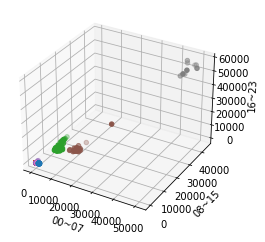

Figure 4.14: K-Means with US-1


In [20]:
# Table 4.5: Subnets in Each cluster - n_clusters=8
# Figure 4.14: K-Means with US-1

data_choose = data_us_1

n_cluster = 8

hour_period = [['00', '01', '02', '03', '04', '05', '06', '07'], ['08', '09', '10', '11', '12', '13', '14', '15'], ['16', '17', '18', '19', '20', '21', '22', '23']]

count_period3 = []
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)

X_count_hour3 = np.array(count_period3)

yhat, score = kmeans_cluster(X_count_hour3, n_clusters=n_cluster, pca_components=2, plot=False, show_centers=False)

class_subnet = dict()
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    for i in row_ix[0]:
        subnet = ip_index[i][:10]
        if yhat[i] not in class_subnet:
            class_subnet[yhat[i]] = {subnet: [ip_index[i]]}
        elif subnet not in class_subnet[yhat[i]]:
            class_subnet[yhat[i]][subnet] = [ip_index[i]]
        elif ip_index[i] not in class_subnet[yhat[i]][subnet]:
            class_subnet[yhat[i]][subnet].append(ip_index[i])
class_subnet
for _class in class_subnet:
    print(f'\ncluster {_class}')
    for key, value in class_subnet[_class].items():
        print(f'{key}({len(value)})')
        
print('\nTable 4.5: Subnets in Each cluster - n_clusters=8')

# 3d plot
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')

ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')

ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')

clusters = np.unique(yhat)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    ax.scatter(X_count_hour3[row_ix, 0], X_count_hour3[row_ix, 1], X_count_hour3[row_ix, 2], color=colors[cluster])

pyplot.show()

print('Figure 4.14: K-Means with US-1')

In [21]:
def avg_class_periods_count(data_1, data_2, ip_list, hour_period):
    period_count_1 = np.zeros((len(hour_period),), dtype=int)
    period_count_2 = np.zeros((len(hour_period),), dtype=int)
    for ip in ip_list:
        for time in data_1[ip]:
            hour = time[11:13]
            for i in range(len(hour_period)):
                if hour in hour_period[i]:
                    period_count_1[i] += 1
        for time in data_2[ip]:
            hour = time[11:13]
            for i in range(len(hour_period)):
                if hour in hour_period[i]:
                    period_count_2[i] += 1
    for i in range(len(hour_period)):
        period_count_1[i] /= len(ip_list)
        period_count_2[i] /= len(ip_list)
    return period_count_1, period_count_2

In [22]:
# Table 4.6: The Average 3-Period Transaction Count in US-1 and US-All

# clustering
data_choose = data_us_1
n_cluster = 8
hour_period = [['00', '01', '02', '03', '04', '05', '06', '07'], ['08', '09', '10', '11', '12', '13', '14', '15'], ['16', '17', '18', '19', '20', '21', '22', '23']]

count_period3 = []
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)

yhat, score = kmeans_cluster(X_count_hour3, n_clusters=n_cluster, pca_components=2, plot=False, show_centers=False)

# set class_subnet
class_subnet = dict()
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    for i in row_ix[0]:
        subnet = ip_index[i][:10]
        if yhat[i] not in class_subnet:
            class_subnet[yhat[i]] = {subnet: [ip_index[i]]}
        elif subnet not in class_subnet[yhat[i]]:
            class_subnet[yhat[i]][subnet] = [ip_index[i]]
        elif ip_index[i] not in class_subnet[yhat[i]][subnet]:
            class_subnet[yhat[i]][subnet].append(ip_index[i])

# show result - The Average 3-Period Transaction Count
for _class in class_subnet:
    print(f'cluster-{_class}')
    class_row = np.where(yhat == _class)[0]
    class_ip_list = []
    for subnet in class_subnet[_class]:
        for _ip in class_subnet[_class][subnet]:
            class_ip_list.append(_ip)        
    avg_us_1, avg_us_all = avg_class_periods_count(data_us_1, data_us_all, ip_list=class_ip_list, hour_period=hour_period)
    print(f'US-1: {avg_us_1}')
    print(f'US-All: {avg_us_all}\n')

print('Table 4.6: The Average 3-Period Transaction Count in US-1 and US-All')

cluster-0
US-1: [1585    2  238]
US-All: [3615  153 1054]

cluster-1
US-1: [40  0 12]
US-All: [40  0 16]

cluster-2
US-1: [ 4378 10598  4707]
US-All: [ 5624 18249  5700]

cluster-3
US-1: [150   0  52]
US-All: [150   0  69]

cluster-4
US-1: [325  52  97]
US-All: [ 475 1032  244]

cluster-5
US-1: [14082  9723  8203]
US-All: [19878 12157 12240]

cluster-6
US-1: [1008    1  133]
US-All: [3020  106  816]

cluster-7
US-1: [47243 40019 54505]
US-All: [144784 100580 131880]

Table 4.6: The Average 3-Period Transaction Count in US-1 and US-All


In [23]:
def mean_shift_cluster(model, pca_components=False, plot_3d=False, plot_2d=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model_3d = model
        model = pca.transform(model)
    clustering = MeanShift().fit(model)
    yhat = clustering.labels_
    clusters = np.unique(yhat)
    print(f'n_cluster: {len(clusters)}')
    score = S_Dbw(model, yhat)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    if (plot_2d):
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            pyplot.scatter(model[row_ix, 0], model[row_ix, 1], color=colors[cluster])
        pyplot.show()
        print(f'S_Dbw: {score}\n')
        
    if (plot_3d):
        fig = pyplot.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')
        ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')
        ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            ax.scatter(model_3d[row_ix, 0], model_3d[row_ix, 1], model_3d[row_ix, 2], color=colors[cluster])
            print(f'class_{cluster}({colors[cluster][4:]}): {[round(np.mean(model_3d[row_ix, 0])), round(np.mean(model_3d[row_ix, 1])), round(np.mean(model_3d[row_ix, 2]))]}')
        pyplot.show()
    return yhat, score , len(clusters) # clustering result, S_Dbw Score, n_cluster


n_cluster: 8


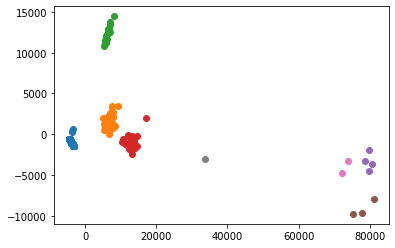

S_Dbw: 0.09724028806489697

class_0(blue): [654, 11, 109]
class_1(orange): [5778, 7831, 6078]
class_2(green): [1332, 16628, 1723]
class_3(red): [13711, 9409, 7681]
class_4(purple): [46878, 42820, 55720]
class_5(brown): [49086, 37101, 55913]
class_6(pink): [45211, 38794, 49966]
class_7(gray): [24496, 18525, 22820]


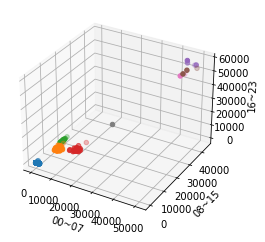

Figure 4.15: Mean-Shift with n_periods=3 and slide_hour=0
Table 4.7: Centers of the clusters in Mean Shift


In [24]:
# Figure 4.15: Mean-Shift with n_periods=3 and slide_hour=0
# Table 4.7: Centers of the clusters in Mean Shift

data_choose = data_us_1
hour_period = [['00', '01', '02', '03', '04', '05', '06', '07'], ['08', '09', '10', '11', '12', '13', '14', '15'], ['16', '17', '18', '19', '20', '21', '22', '23']]

count_period3 = []
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)

labels, score , n_clusters_ = mean_shift_cluster(X_count_hour3, pca_components=2, plot_3d=True, plot_2d=True)

print('Figure 4.15: Mean-Shift with n_periods=3 and slide_hour=0')
print('Table 4.7: Centers of the clusters in Mean Shift')